# DC-GAN - Type 0 - Diabetic Retinopathy

In [1]:
import os
import sys
import glob
import json
import random
import argparse
import subprocess
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.utils as vutils
import torchvision.datasets as dset
import torchvision.transforms as transforms

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
os.environ[ "CUDA_VISIBLE_DEVICES" ]="4"

In [4]:
seed = 786
random.seed(seed)
torch.manual_seed(seed)

### HyperParameters

In [5]:
params = {
    "bsize" : 8, # Batch size during training.
    'imsize' : 360, # Spatial size of training images.
    'nc' : 3, # Number of channles in the training images.
    'nz' : 100, # Size of the Z latent vector.
    'ngf' : 32, # Size of feature maps in the generator.
    'ndf' : 64, # Size of features maps in the discriminator.
    'nepochs' : 25, # Number of training epochs.
    'lr' : 0.0002, # Learning rate for optimizers
    'beta1' : 0.5, # Beta1 hyperparam for Adam optimizer
    'save_epoch' : 5 # Save step.
}

### Data Loader

In [6]:
root = './dataset/dcgan_v3/train0'

def load_dataset(params):
    # Data proprecessing.
    
    transform = transforms.Compose([
        transforms.Resize(params['imsize']),
        transforms.CenterCrop(params['imsize']),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5),
            (0.5, 0.5, 0.5))])

    dataset = dset.ImageFolder(root=root, transform=transform)

    dataloader = torch.utils.data.DataLoader(dataset,
        batch_size=params['bsize'],
        shuffle=True, num_workers= 16)

    return dataloader

In [7]:
device = torch.device("cuda" if(torch.cuda.is_available()) else "cpu")

### Training Samples

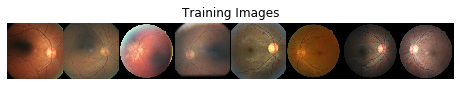

In [8]:
dataloader = load_dataset(params)

sample_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(
   sample_batch[0].to(device)[ : 64], padding=2, normalize=True).cpu(), (1, 2, 0)))

plt.show()

## Discriminator, Generator & Parameter Definitions

In [9]:
def weights_init(w):
    classname = w.__class__.__name__
    if classname.find('conv') != -1:
        nn.init.normal_(w.weight.data, 0.0, 0.02)
    elif classname.find('bn') != -1:
        nn.init.normal_(w.weight.data, 1.0, 0.02)
        nn.init.constant_(w.bias.data, 0)

In [10]:
class Generator(nn.Module):
    def __init__(self, params):
        super().__init__()

        self.tconv1 = nn.ConvTranspose2d(params['nz'], params['ngf']*8*2,
            kernel_size=5, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(params['ngf']*8*2)
        
        self.tconv2 = nn.ConvTranspose2d(params['ngf']*8*2, params['ngf']*4*2,
            5, 3, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(params['ngf']*4*2)

        self.tconv3 = nn.ConvTranspose2d(params['ngf']*4*2, params['ngf']*2*2,
            5, 3, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(params['ngf']*2*2)

        self.tconv4 = nn.ConvTranspose2d(params['ngf']*2*2, params['ngf']*2,
            4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(params['ngf']*2)

        self.tconv5 = nn.ConvTranspose2d(params['ngf']*2, params['ngf'],
            4, 2, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(params['ngf'])

        self.tconv7 = nn.ConvTranspose2d(params['ngf'], params['nc'],
            4, 2, 1, bias=False)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.tconv1(x)))
        x = F.relu(self.bn2(self.tconv2(x)))
        x = F.relu(self.bn3(self.tconv3(x)))
        x = F.relu(self.bn4(self.tconv4(x)))
        x = F.relu(self.bn5(self.tconv5(x)))
        x = F.tanh(self.tconv7(x))
        return x

In [11]:
class Discriminator(nn.Module):
    def __init__(self, params):
        super().__init__()

        self.conv1 = nn.Conv2d(params['nc'], params['ndf'],
            4, 2, 1, bias=False)

        self.conv2 = nn.Conv2d(params['ndf'], params['ndf']*2,
            4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(params['ndf']*2)

        self.conv3 = nn.Conv2d(params['ndf']*2, params['ndf']*4,
            4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(params['ndf']*4)

        self.conv4 = nn.Conv2d(params['ndf']*4, params['ndf']*8,
            5, 3, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(params['ndf']*8)

        self.conv5 = nn.Conv2d(params['ndf']*8, params['ndf']*16,
            5, 3, 1, bias=False)
        self.bn5 = nn.BatchNorm2d(params['ndf']*16)

        self.conv6 = nn.Conv2d(params['ndf']*16, 1, 5, 1, 0, bias=False)


    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2, True)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2, True)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2, True)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2, True)
        x = F.leaky_relu(self.bn5(self.conv5(x)), 0.2, True)
        x = F.sigmoid(self.conv6(x))

        return x

In [12]:
netG = Generator(params).to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (tconv1): ConvTranspose2d(100, 512, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv2): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv3): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv5): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv7): ConvTranspose2d(32, 3, kernel_size=(4, 4), 

In [13]:
netD = Discriminator(params).to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1024, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1), bias=False)
  (bn5): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(1024, 1, kernel_size=(5, 5), stride=(1, 1), bias=False)
)


In [14]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, params['nz'], 1, 1, device=device)

real_label = 1
fake_label = 0

In [15]:
optimizerD = optim.Adam(netD.parameters(), lr=params['lr'], betas=(params['beta1'], 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=params['lr'], betas=(params['beta1'], 0.999))

In [16]:
# Stores generated images as training progresses.
img_list = []

# Stores generator losses during training.
G_losses = []

# Stores discriminator losses during training.
D_losses = []

iters = 0

## Training

In [17]:
print("Starting Training Loop...")
print("-"*25)

for epoch in range(params['nepochs']):
    batches_done = 0
    for i, data in enumerate(dataloader, 0):
        batches_done +=1
        real_data = data[0].to(device)
        b_size = real_data.size(0)
        
        netD.zero_grad()
        label = torch.full((b_size, ), real_label, device=device)
        output = netD(real_data).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        
        noise = torch.randn(b_size, params['nz'], 1, 1, device=device)
        fake_data = netG(noise)
        label.fill_(fake_label  )
        output = netD(fake_data.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        optimizerD.step()
        
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake_data).view(-1)
        errG = criterion(output, label)
        errG.backward()

        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i%100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, params['nepochs'], i+1, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 250 == 0) or ((epoch == params['nepochs']-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake_data = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake_data, padding=2, normalize=True))

        iters += 1

    if epoch % params['save_epoch'] == 0:
        torch.save({
            'generator' : netG.state_dict(),
            'discriminator' : netD.state_dict(),
            'optimizerG' : optimizerG.state_dict(),
            'optimizerD' : optimizerD.state_dict(),
            'params' : params
            }, 'model/type0/model_epoch_{}.pth'.format(epoch+1))

Starting Training Loop...
-------------------------


/raid/mlcysec19/software/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/raid/mlcysec19/software/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[1/25][1/3227]	Loss_D: 1.3375	Loss_G: 16.5710	D(x): 0.4944	D(G(z)): 0.4576 / 0.0000
[1/25][101/3227]	Loss_D: 0.0144	Loss_G: 12.9663	D(x): 0.9862	D(G(z)): 0.0000 / 0.0000
[1/25][201/3227]	Loss_D: 0.4748	Loss_G: 16.0528	D(x): 0.9999	D(G(z)): 0.3216 / 0.0000
[1/25][301/3227]	Loss_D: 0.0201	Loss_G: 7.3933	D(x): 0.9996	D(G(z)): 0.0192 / 0.0065
[1/25][401/3227]	Loss_D: 0.0041	Loss_G: 8.5154	D(x): 0.9970	D(G(z)): 0.0011 / 0.0003
[1/25][501/3227]	Loss_D: 0.0000	Loss_G: 11.3356	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/25][601/3227]	Loss_D: 0.0002	Loss_G: 9.2295	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[1/25][701/3227]	Loss_D: 0.0003	Loss_G: 8.6158	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[1/25][801/3227]	Loss_D: 0.0000	Loss_G: 19.0372	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/25][901/3227]	Loss_D: 0.0001	Loss_G: 17.2743	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[1/25][1001/3227]	Loss_D: 0.2551	Loss_G: 4.0426	D(x): 0.8261	D(G(z)): 0.0051 / 0.0385
[1/25][1101/3227]	Loss_D: 0.4153	Loss_G: 3.2327	D(x): 0.7711

[3/25][3001/3227]	Loss_D: 0.0027	Loss_G: 10.2863	D(x): 0.9990	D(G(z)): 0.0016 / 0.0013
[3/25][3101/3227]	Loss_D: 0.0052	Loss_G: 4.0996	D(x): 0.9999	D(G(z)): 0.0051 / 0.0516
[3/25][3201/3227]	Loss_D: 0.0034	Loss_G: 9.4534	D(x): 0.9972	D(G(z)): 0.0005 / 0.0002
[4/25][1/3227]	Loss_D: 0.0779	Loss_G: 13.2578	D(x): 0.9343	D(G(z)): 0.0001 / 0.0000
[4/25][101/3227]	Loss_D: 0.0633	Loss_G: 8.7605	D(x): 0.9406	D(G(z)): 0.0005 / 0.0008
[4/25][201/3227]	Loss_D: 0.0717	Loss_G: 7.7000	D(x): 0.9394	D(G(z)): 0.0044 / 0.0081
[4/25][301/3227]	Loss_D: 0.0546	Loss_G: 8.2563	D(x): 0.9942	D(G(z)): 0.0419 / 0.0009
[4/25][401/3227]	Loss_D: 0.0360	Loss_G: 6.7318	D(x): 0.9714	D(G(z)): 0.0056 / 0.0106
[4/25][501/3227]	Loss_D: 0.0258	Loss_G: 11.6273	D(x): 0.9751	D(G(z)): 0.0001 / 0.0000
[4/25][601/3227]	Loss_D: 0.0215	Loss_G: 7.8921	D(x): 0.9830	D(G(z)): 0.0042 / 0.0019
[4/25][701/3227]	Loss_D: 0.0009	Loss_G: 12.4006	D(x): 0.9995	D(G(z)): 0.0004 / 0.0002
[4/25][801/3227]	Loss_D: 0.3537	Loss_G: 4.4820	D(x): 0.8590	

[6/25][2701/3227]	Loss_D: 0.0122	Loss_G: 8.3422	D(x): 0.9999	D(G(z)): 0.0118 / 0.0077
[6/25][2801/3227]	Loss_D: 0.0005	Loss_G: 13.3375	D(x): 0.9996	D(G(z)): 0.0001 / 0.0000
[6/25][2901/3227]	Loss_D: 0.4983	Loss_G: 0.3799	D(x): 0.6912	D(G(z)): 0.0090 / 0.7044
[6/25][3001/3227]	Loss_D: 0.0017	Loss_G: 8.5243	D(x): 0.9996	D(G(z)): 0.0013 / 0.0009
[6/25][3101/3227]	Loss_D: 0.0168	Loss_G: 8.0579	D(x): 0.9995	D(G(z)): 0.0159 / 0.0017
[6/25][3201/3227]	Loss_D: 0.0013	Loss_G: 9.0343	D(x): 0.9999	D(G(z)): 0.0012 / 0.0004
[7/25][1/3227]	Loss_D: 0.0010	Loss_G: 11.1853	D(x): 0.9991	D(G(z)): 0.0001 / 0.0001
[7/25][101/3227]	Loss_D: 0.1341	Loss_G: 10.2539	D(x): 1.0000	D(G(z)): 0.0888 / 0.0001
[7/25][201/3227]	Loss_D: 0.0030	Loss_G: 9.3795	D(x): 0.9973	D(G(z)): 0.0002 / 0.0003
[7/25][301/3227]	Loss_D: 0.0203	Loss_G: 9.8341	D(x): 0.9998	D(G(z)): 0.0187 / 0.0031
[7/25][401/3227]	Loss_D: 0.0011	Loss_G: 9.0408	D(x): 1.0000	D(G(z)): 0.0011 / 0.0010
[7/25][501/3227]	Loss_D: 0.0100	Loss_G: 19.4050	D(x): 0.99

[9/25][2401/3227]	Loss_D: 0.0054	Loss_G: 9.2036	D(x): 0.9952	D(G(z)): 0.0006 / 0.0002
[9/25][2501/3227]	Loss_D: 0.0004	Loss_G: 13.6091	D(x): 0.9997	D(G(z)): 0.0001 / 0.0000
[9/25][2601/3227]	Loss_D: 0.6344	Loss_G: 23.9131	D(x): 0.8745	D(G(z)): 0.0000 / 0.0000
[9/25][2701/3227]	Loss_D: 0.0088	Loss_G: 15.4055	D(x): 0.9918	D(G(z)): 0.0004 / 0.0002
[9/25][2801/3227]	Loss_D: 0.0020	Loss_G: 9.4578	D(x): 0.9984	D(G(z)): 0.0004 / 0.0002
[9/25][2901/3227]	Loss_D: 0.0006	Loss_G: 11.7999	D(x): 1.0000	D(G(z)): 0.0006 / 0.0004
[9/25][3001/3227]	Loss_D: 0.0011	Loss_G: 8.9840	D(x): 1.0000	D(G(z)): 0.0011 / 0.0011
[9/25][3101/3227]	Loss_D: 0.0000	Loss_G: 18.5674	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[9/25][3201/3227]	Loss_D: 0.0037	Loss_G: 8.6384	D(x): 1.0000	D(G(z)): 0.0036 / 0.0027
[10/25][1/3227]	Loss_D: 0.0020	Loss_G: 10.2864	D(x): 1.0000	D(G(z)): 0.0020 / 0.0144
[10/25][101/3227]	Loss_D: 0.1942	Loss_G: 7.0410	D(x): 0.8893	D(G(z)): 0.0068 / 0.0072
[10/25][201/3227]	Loss_D: 0.0011	Loss_G: 12.3378	D

[12/25][2001/3227]	Loss_D: 0.0010	Loss_G: 10.3712	D(x): 0.9996	D(G(z)): 0.0007 / 0.0006
[12/25][2101/3227]	Loss_D: 0.0005	Loss_G: 17.9841	D(x): 1.0000	D(G(z)): 0.0005 / 0.0032
[12/25][2201/3227]	Loss_D: 0.0753	Loss_G: 10.4369	D(x): 1.0000	D(G(z)): 0.0671 / 0.0068
[12/25][2301/3227]	Loss_D: 0.0005	Loss_G: 8.9683	D(x): 1.0000	D(G(z)): 0.0005 / 0.0006
[12/25][2401/3227]	Loss_D: 0.0019	Loss_G: 7.0100	D(x): 0.9995	D(G(z)): 0.0014 / 0.0014
[12/25][2501/3227]	Loss_D: 0.0223	Loss_G: 7.3182	D(x): 1.0000	D(G(z)): 0.0216 / 0.0102
[12/25][2601/3227]	Loss_D: 0.0008	Loss_G: 14.6904	D(x): 0.9995	D(G(z)): 0.0003 / 0.0002
[12/25][2701/3227]	Loss_D: 0.0072	Loss_G: 7.4169	D(x): 1.0000	D(G(z)): 0.0071 / 0.0048
[12/25][2801/3227]	Loss_D: 0.0043	Loss_G: 6.9054	D(x): 1.0000	D(G(z)): 0.0042 / 0.0048
[12/25][2901/3227]	Loss_D: 0.0036	Loss_G: 8.0402	D(x): 1.0000	D(G(z)): 0.0035 / 0.0022
[12/25][3001/3227]	Loss_D: 0.0036	Loss_G: 9.5539	D(x): 0.9973	D(G(z)): 0.0010 / 0.0007
[12/25][3101/3227]	Loss_D: 0.0000	Loss_

[15/25][1501/3227]	Loss_D: 0.0004	Loss_G: 22.5439	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[15/25][1601/3227]	Loss_D: 0.0589	Loss_G: 7.3153	D(x): 0.9982	D(G(z)): 0.0498 / 0.0063
[15/25][1701/3227]	Loss_D: 0.0000	Loss_G: 15.5021	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[15/25][1801/3227]	Loss_D: 0.0014	Loss_G: 7.9779	D(x): 1.0000	D(G(z)): 0.0014 / 0.0011
[15/25][1901/3227]	Loss_D: 0.0000	Loss_G: 11.2869	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[15/25][2001/3227]	Loss_D: 0.0012	Loss_G: 7.5514	D(x): 1.0000	D(G(z)): 0.0012 / 0.0010
[15/25][2101/3227]	Loss_D: 0.0231	Loss_G: 7.4984	D(x): 0.9815	D(G(z)): 0.0031 / 0.0034
[15/25][2201/3227]	Loss_D: 0.0466	Loss_G: 8.2177	D(x): 0.9999	D(G(z)): 0.0421 / 0.0006
[15/25][2301/3227]	Loss_D: 0.0000	Loss_G: 13.3419	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[15/25][2401/3227]	Loss_D: 0.0002	Loss_G: 13.8229	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[15/25][2501/3227]	Loss_D: 0.0001	Loss_G: 19.9275	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[15/25][2601/3227]	Loss_D: 0.1263	Los

[18/25][1101/3227]	Loss_D: 0.0000	Loss_G: 17.5864	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[18/25][1201/3227]	Loss_D: 0.0028	Loss_G: 17.0557	D(x): 1.0000	D(G(z)): 0.0028 / 0.0020
[18/25][1301/3227]	Loss_D: 0.0281	Loss_G: 5.2483	D(x): 1.0000	D(G(z)): 0.0268 / 0.0262
[18/25][1401/3227]	Loss_D: 0.0000	Loss_G: 16.4392	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[18/25][1501/3227]	Loss_D: 0.0042	Loss_G: 8.9641	D(x): 1.0000	D(G(z)): 0.0041 / 0.0025
[18/25][1601/3227]	Loss_D: 0.0001	Loss_G: 10.2282	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[18/25][1701/3227]	Loss_D: 0.0000	Loss_G: 12.8992	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[18/25][1801/3227]	Loss_D: 0.0000	Loss_G: 16.6264	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[18/25][1901/3227]	Loss_D: 0.0006	Loss_G: 9.8192	D(x): 1.0000	D(G(z)): 0.0006 / 0.0006
[18/25][2001/3227]	Loss_D: 0.0002	Loss_G: 13.0912	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[18/25][2101/3227]	Loss_D: 0.0030	Loss_G: 7.2066	D(x): 1.0000	D(G(z)): 0.0030 / 0.0023
[18/25][2201/3227]	Loss_D: 0.0114	Lo

[21/25][601/3227]	Loss_D: 0.0002	Loss_G: 12.7138	D(x): 1.0000	D(G(z)): 0.0002 / 0.0026
[21/25][701/3227]	Loss_D: 0.0095	Loss_G: 7.2675	D(x): 0.9984	D(G(z)): 0.0078 / 0.0022
[21/25][801/3227]	Loss_D: 0.3516	Loss_G: 11.8866	D(x): 1.0000	D(G(z)): 0.2097 / 0.0000
[21/25][901/3227]	Loss_D: 0.0005	Loss_G: 9.8147	D(x): 1.0000	D(G(z)): 0.0005 / 0.0005
[21/25][1001/3227]	Loss_D: 0.0004	Loss_G: 9.4466	D(x): 1.0000	D(G(z)): 0.0004 / 0.0004
[21/25][1101/3227]	Loss_D: 1.2541	Loss_G: 14.3354	D(x): 0.6635	D(G(z)): 0.0000 / 0.0001
[21/25][1201/3227]	Loss_D: 0.0024	Loss_G: 9.2073	D(x): 0.9980	D(G(z)): 0.0003 / 0.0004
[21/25][1301/3227]	Loss_D: 0.0002	Loss_G: 15.1901	D(x): 1.0000	D(G(z)): 0.0002 / 0.0000
[21/25][1401/3227]	Loss_D: 0.0018	Loss_G: 7.9384	D(x): 1.0000	D(G(z)): 0.0018 / 0.0011
[21/25][1501/3227]	Loss_D: 0.0001	Loss_G: 14.3221	D(x): 1.0000	D(G(z)): 0.0001 / 0.0000
[21/25][1601/3227]	Loss_D: 0.0014	Loss_G: 12.8705	D(x): 1.0000	D(G(z)): 0.0014 / 0.0012
[21/25][1701/3227]	Loss_D: 0.0001	Loss_G:

[24/25][101/3227]	Loss_D: 0.0000	Loss_G: 15.4596	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[24/25][201/3227]	Loss_D: 0.0001	Loss_G: 13.4673	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[24/25][301/3227]	Loss_D: 0.1640	Loss_G: 6.4747	D(x): 0.9040	D(G(z)): 0.0011 / 0.0045
[24/25][401/3227]	Loss_D: 0.0489	Loss_G: 10.2688	D(x): 1.0000	D(G(z)): 0.0414 / 0.0008
[24/25][501/3227]	Loss_D: 0.0002	Loss_G: 11.5315	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[24/25][601/3227]	Loss_D: 0.0161	Loss_G: 11.2509	D(x): 1.0000	D(G(z)): 0.0153 / 0.0046
[24/25][701/3227]	Loss_D: 0.0011	Loss_G: 10.0185	D(x): 0.9999	D(G(z)): 0.0010 / 0.0008
[24/25][801/3227]	Loss_D: 0.6624	Loss_G: 8.1477	D(x): 0.7729	D(G(z)): 0.0000 / 0.0009
[24/25][901/3227]	Loss_D: 0.0003	Loss_G: 9.6890	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003
[24/25][1001/3227]	Loss_D: 0.0005	Loss_G: 10.0845	D(x): 1.0000	D(G(z)): 0.0005 / 0.0005
[24/25][1101/3227]	Loss_D: 0.0006	Loss_G: 8.9156	D(x): 1.0000	D(G(z)): 0.0005 / 0.0004
[24/25][1201/3227]	Loss_D: 0.0090	Loss_G: 11.

In [18]:
# Final Trained Model.

torch.save({
            'generator' : netG.state_dict(),
            'discriminator' : netD.state_dict(),
            'optimizerG' : optimizerG.state_dict(),
            'optimizerD' : optimizerD.state_dict(),
            'params' : params
            }, 'model/type0/model_final.pth')

In [19]:
with open('model/type0/G_losses_type0.json', 'w') as f:
    json.dump(G_losses, f)

with open('model/type0/D_losses_type0.json', 'w') as f:
    json.dump(D_losses, f)

### Discriminator vs Generator Loss Plot

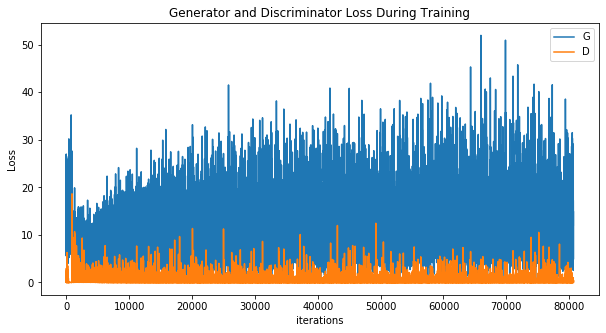

In [20]:
# Plot the Training Losses.

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('./generated_images/type0/discriminator_generator_loss_plot_type0.png')
plt.show()

## Sample Generation from Trained Model

### Sample from each Epoch

In [21]:
with tqdm(params['nepochs']) as pbar:
    for epoch in range(0,params['nepochs'],5):
        path = f'model/type0/model_epoch_{epoch+1}.pth'
        state_dict = torch.load(path,map_location='cpu')

        device = torch.device("cuda")
        params = state_dict['params']

        netG = Generator(params).to(device)
        netG.load_state_dict(state_dict['generator'])

        for i in range(10):
            noise = torch.randn(1, params['nz'], 1, 1, device=device)

            with torch.no_grad():
                generated_img = netG(noise).detach().cpu()

            image_data = np.transpose(vutils.make_grid(generated_img, padding=2, normalize=True), (1,2,0))
            plt.imsave(fname=f'./generated_images/type0/pic_generated_{epoch}_{i+1}.png', arr=np.asarray(image_data))
        pbar.update(5)

25it [00:09,  2.52it/s]


### Samples from Final Epoch

In [22]:
path = f'model/type0/model_final.pth'
state_dict = torch.load(path,map_location='cpu')
device = torch.device("cuda")
params = state_dict['params']

netG = Generator(params).to(device)
netG.load_state_dict(state_dict['generator'])

with tqdm(1000) as pbar:
    for i in range(1000):
        noise = torch.randn(1, params['nz'], 1, 1, device=device)
        with torch.no_grad():
            generated_img = netG(noise).detach().cpu()
        
        image_data = np.transpose(vutils.make_grid(generated_img, padding=2, normalize=True), (1,2,0))
        plt.imsave(fname=f'./generated_images/0_{i+1}.png', arr=np.asarray(image_data))
        pbar.update(1)

1000it [02:45,  6.05it/s]


### Learning Transitions across Epochs (Animation)

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


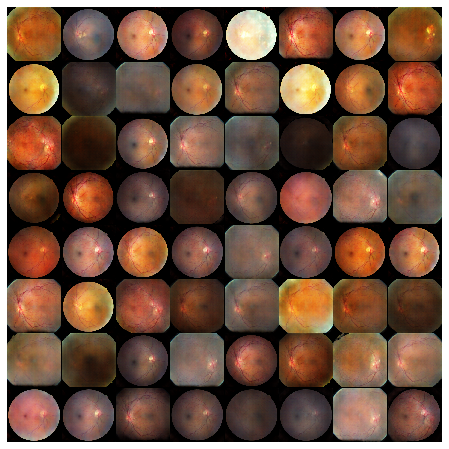

In [23]:
# Animation showing the overall improvements of the generator during the training.

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
anim = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
anim.save('./generated_images/type0/fundus_type0.gif', dpi=80, writer='imagemagick')

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


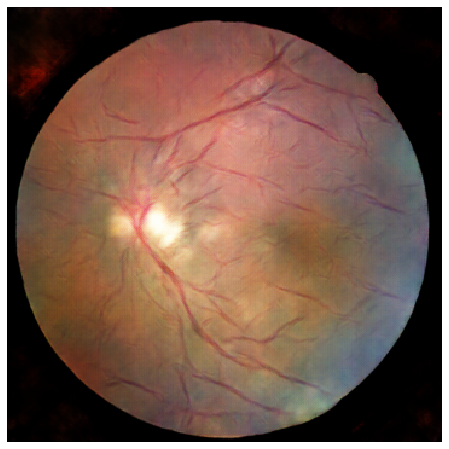

In [24]:
# Animation showing the improvements of the generator for across epoch from generated samples.

img_list = map(plt.imread, sorted(glob.glob('./generated_images/type0/*10.png')))
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(i, animated=True)] for i in img_list]
anim = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
anim.save('./generated_images/type0/fundus_type0_1.gif', dpi=80, writer='imagemagick')